In [1]:
from fastai.vision.all import *

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('subset.csv')

In [4]:
def get_caption_embedding(caption_embedding):
    value=caption_embedding.split(',')
    value.pop(0)
    embedding_val = [float(i) for i in value]
    return embedding_val

In [5]:
def get_x(r): return r['img']
def get_y(r): return get_caption_embedding(r['caption_embedding'])

In [6]:
dblocks = DataBlock((ImageBlock,RegressionBlock),
                       get_x= get_x,
                       get_y = get_y,
                       batch_tfms=[*aug_transforms(size=(240,320)),Normalize.from_stats(*imagenet_stats)])
dls=dblocks.dataloaders(df)

In [12]:
def cos_loss(preds, target):
    return 1 - F.cosine_similarity(preds, target).mean()

In [13]:
learn = cnn_learner(dls, resnet18, y_range=(0,1),metrics=accuracy_multi,loss_func=cos_loss)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.03981071710586548)

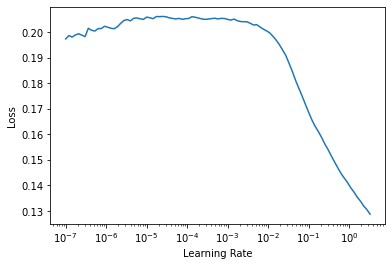

In [14]:
learn.lr_find()

In [15]:
lr = 1e-1
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.064853,0.051035,0.990437,00:15


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.043189,0.041560,0.990437,00:18
1,0.042664,0.040314,0.990437,00:18
2,0.040810,0.040005,0.990437,00:18


# Lets run the evalution on all the dataset and store it in Annoy Index

In [46]:
train_csv = pd.read_csv('train.csv')
test_csv = pd.read_csv('test.csv')
val_csv=pd.read_csv('val.csv')

In [47]:
df = train_csv.append([test_csv, val_csv])

In [49]:
test_dl = dls.test_dl(df,with_labels=True)

In [50]:
preds = learn.get_preds(dl=test_dl)
learn.validate(dl=test_dl)

(#2) [0.04111364111304283,0.9880971312522888]

In [53]:
from annoy import AnnoyIndex
f = 300
t = AnnoyIndex(f, 'angular')

In [54]:
image_2_id=[];
for batch_idx, img_embedding in enumerate(preds[0]):
    val=df.iloc[batch_idx]
    image_2_id.append({'id':batch_idx,'img_path':val.img})
    embedding = np.array(img_embedding.cpu())
    t.add_item(batch_idx, embedding)

In [55]:
t.build(10) # 10 trees
t.save('image_em.ann')

True

In [56]:
u = AnnoyIndex(f, 'angular')
u.load('test.ann') # super fast, will just mmap the file
print(u.get_nns_by_item(0, 100))

[0, 46170, 5224, 21996, 27149, 20767, 7928, 37472, 23300, 2072, 10436, 22751, 12979, 18899, 19527, 3432, 5944, 52221, 12849, 19831, 54857, 20902, 36111, 35433, 26374, 35436, 16014, 6159, 48668, 37164, 31872, 53907, 2365, 23853, 15568, 48586, 16500, 23220, 21612, 44516, 5000, 27251, 43325, 42667, 30157, 46499, 45248, 36556, 50838, 4719, 1564, 36789, 43954, 15168, 4766, 54188, 8960, 13847, 8658, 9012, 4534, 34695, 4979, 46003, 20450, 33078, 14319, 33883, 33604, 27102, 29371, 6217, 29241, 27630, 1074, 8985, 21461, 250, 33692, 34178, 53943, 32889, 23622, 59169, 47529, 53352, 25471, 25544, 43964, 42052, 11695, 7676, 1320, 24069, 9780, 19408, 44361, 54580, 55301, 15984]


In [57]:
len(image_2_id)

1000000

In [58]:
val_index = pd.DataFrame(image_2_id)

In [59]:
val_index.head()

,id,img_path
0,0,img_resized_1M/cities_instagram/chicago/1482025253408147333.jpg
1,1,img_resized_1M/cities_instagram/miami/1489862958418184034.jpg
2,2,img_resized_1M/cities_instagram/london/1490670801451901341.jpg
3,3,img_resized_1M/cities_instagram/losangeles/1490593685564481529.jpg
4,4,img_resized_1M/cities_instagram/sydney/1480253413722844675.jpg


In [60]:
val_index.to_csv('id_2_img.csv')

In [ ]:
lear